# Project : *[A Bayesian reassessment of nearest-neighbour classification](https://arxiv.org/pdf/0802.1357.pdf)*
### Tom Rivero, Sacha Dedeken | M2 Data Science | Bayesian Machine Learning

#### Step 1 : Import packages and dataset

We use [the original KNN from the scikit learn library](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), and data of [the Haberman's Survival Dataset](https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival) from the UCI Machine Learning Repository. We initially wanted to use the **MASS** dataset used in the paper, but we were unable to import it.

As you can see below, the dataset contains the survival of 306 patients (age, year of the operation, number of positive axillary nodes) 5 years after having undergone surgery for breast cancer between 1958 and 1969. So we have $X \in \mathbb{N}^{306\times3}$ and $y \in \{0,1\}^{306}$. The goal is to do binary classification on $y$ based on $X$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("haberman.data", names=["age", "operation_year", "nodes", "survival_status"])
df["survival_status"] -= 1 #put labels to {0,1} instead of {1,2}
df

,age,operation_year,nodes,survival_status
0,30,64,1,0
1,30,62,3,0
2,30,65,0,0
3,31,59,2,0
4,31,65,4,0
...,...,...,...,...
301,75,62,1,0
302,76,67,0,0
303,77,65,3,0
304,78,65,1,1


In [3]:
df.describe()

,age,operation_year,nodes,survival_status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,0.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,0.000000
25%,44.000000,60.000000,0.000000,0.000000
50%,52.000000,63.000000,1.000000,0.000000
75%,60.750000,65.750000,4.000000,1.000000
max,83.000000,69.000000,52.000000,1.000000


We split randomly the dataset into a train and a test set with a random_state for reproducibility.

In [4]:
X, y = df[df.columns[:-1]].to_numpy(), df[df.columns[-1]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

K = min(np.unique(y_train, return_counts=True)[1]) # =64, maximum K we can pick for knn
print(K)

64


#### Step 2 : Probabilistic modelling

In [5]:
def all_k_neighbors(K, X, point_to_pred=None):
    """Computes once every k-neighbors of every points for k in {1,K}

    Args:
        K (int): maximum number of neighbors
        X (2D-array): trainset
        point_to_pred (1D-array): point from test set that one wants to predict, default to None

    Returns:
        3D-list : each index i of the list contains the 2D-array containing the i-neighbors_graph

    """
    if point_to_pred is not None:
        X = np.append(X, np.array([point_to_pred]), axis=0) #append point to pred to X in order to later be able to compute its symetric potts

    M = [None] #set first raw to none since it correspond to k=0
    for n in range(1,K+1):
        graph_n = kneighbors_graph(X, n)
        M.append(graph_n.toarray())
    return M


def symetric_potts(i, y_i, y, Mk):
    """Computes symetric potts as described in equation (4)

    Args:
        i (int): index of point we want to compute the symetric potts
        y_i (int): class of point i
        y (1D-array): array of labels of training points
        Mk (2D-array):  a kneighbors_graph

    Returns:
        int: symetric potts
    """
    #left part : number of neighbors of point i having label y_i
    neighbors_index = np.nonzero(Mk[i])[0]
    sp1 = np.sum(y[neighbors_index] == y_i)

    #right part : number of points that have point i in their k-neighbourhood
    neighbors_index = np.nonzero(Mk[:, i])[0] #get column instead of row
    sp2 =  np.sum(y[neighbors_index] == y_i)

    return sp1 + sp2

#### Step 3 : Pseudo-likelihood approximation

In [6]:
def log_pla(y, beta, k, Mk):
    """"Computes the log (to prevent overflow) of f_hat(=pseudo-likelihood approximation) from formula (8) on page 12

    Args:
        y (1D-array) : array of labels of training
        beta (float) : beta parameter in the formula
        k (int) : k parameter in the formula
        Mk (2D-array) : a kneighbor_graph

    Returns:
        float : log of f_hat from formula (8) on page 12
    """
    nb_points = len(y)
    num, den0, den1 = np.zeros(nb_points), np.zeros(nb_points), np.zeros(nb_points)

    for i in range(nb_points):
        sp0 = symetric_potts(i, 0, y_train, Mk)
        sp1 = symetric_potts(i, 1, y_train, Mk)
        
        num[i] = sp0 if y[i]==0 else sp1
        den0[i] = sp0
        den1 = sp1

    num = np.exp((beta/k)*num)
    den = np.exp((beta/k)*den0) + np.exp((beta/k)*den1)   

    num = np.sum(np.log((num)))
    den = np.sum(np.log((den)))
    return num - den

In [7]:
# Metropolis Hasting
def Q_r(k, r):
  """A uniform distribution on the 2r neighbours of k"""
  neighbours = range(max(1,k-r), min(K,k+r+1))
  return 1 / len(neighbours)

def compute_rho(y, beta, k, new_k, theta, r, M, log_posterior, new_log_posterior):
    
  Q = Q_r(new_k, r) / Q_r(k, r)
  r = np.exp( new_log_posterior - log_posterior ) # = ratio of (non-log) posteriors

  rho = min(r * Q, 1)

  return rho

In [8]:
np.random.seed(666) #set a seed for reproducibility

def metropolis_hasting(r, tau2, beta_max, K, y, X, steps, burn_in_stage):

    samples = np.zeros((steps-burn_in_stage,2))

    # Initialisation of M and parameters 
    M = all_k_neighbors(K, X)
    k = int(K/2)
    theta = 0
    beta = beta_max * np.exp(theta)/(np.exp(theta)+1)
    log_posterior = log_pla(y, beta, k, M[k])

    for i in tqdm(range(steps)):
        #update parameters
        new_k = np.random.choice(range(max(1,k-r), min(K+1, k+r+1))) #draw new k uniformly on the 2r neighbours of old_k
        new_theta = np.random.normal(theta, tau2) #Draw new theta from a normal distribution N(old_theta, tau^2)
        new_beta = beta_max * np.exp(theta)/(np.exp(theta)+1) #logistic reparameterisation of beta (bottom of page 11 in the paper)

        # acceptance probability
        new_log_posterior = log_pla(y, beta, new_k, M[new_k])
        rho = compute_rho(y, new_beta, k, new_k, new_theta, r, M, log_posterior, new_log_posterior)
        
        u = np.random.rand()

        if rho > u : #accept the update
            k, theta, beta = new_k, new_theta, new_beta
            log_posterior = new_log_posterior
            
        if i >= burn_in_stage: #store evolution of variables
            samples[i-burn_in_stage-1] = [k, beta]
        

    return samples

In [9]:
def plots(samples, t):
    """Plot the random walk and the distribution of a sample"""
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(samples)), samples)
    plt.title(t)
    plt.subplot(1, 2, 2)
    plt.hist(samples, bins=K)
    plt.savefig(t+".png")
    plt.show()

In [10]:
#We used values of r, tau^2, beta_max, steps and burn_in_stage of the paper
samples = metropolis_hasting(r=3, tau2=0.05, beta_max=4, K=K,  y=y_train, X=X_train, steps=50000, burn_in_stage=40000)

100%|██████████| 50000/50000 [15:37<00:00, 53.32it/s]


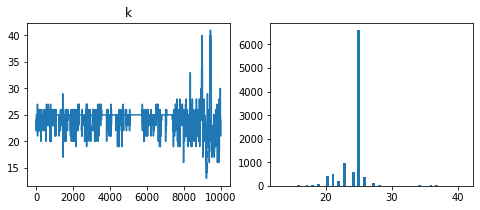

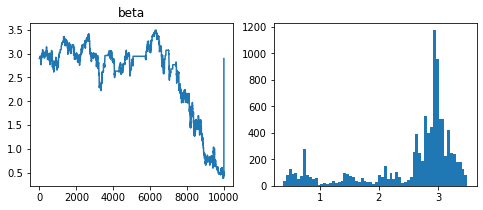

In [11]:
samples_k = samples[:,0]
samples_beta = samples[:,1]
plots(samples_k, 'k')
plots(samples_beta, 'beta')

In [12]:
def predict_probas(samples, X_test):
    y_hat = np.zeros((len(X_test), 2))
    for j in tqdm(range(len(X_test))):
        M_pred = all_k_neighbors(K, X_train, X_test[j]) #computes neighbors of point j and point that have point j in their neighborhood 
        probas = np.zeros((len(samples), 2))
        preds = np.zeros(len(samples))
        for i, s in enumerate(samples):
            k, beta = s
            p0 = np.exp((beta/k)*symetric_potts(-1, 0, y_train, M_pred[int(k)])) #proba of point j to have label 0
            p1 = np.exp((beta/k)*symetric_potts(-1, 1, y_train, M_pred[int(k)])) #proba of point j to have label 1
            p = np.array([p0, p1])
            probas[i] = p / np.sum(p) #normalize to have proper probabilities

        y_hat[j] = np.mean(probas, axis=0) #final estimated probabilities for point j 

    return y_hat

In [13]:
y_hat = predict_probas(samples, X_test)

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


In [14]:
print("Estimated probabilities of each labels for X_train[0]: ",y_hat[0])
print("True label of X_train[0]: ",y_test[0])

Estimated probabilities of each labels for X_train[0]:  [0.8854832 0.1145168]
True label of X_train[0]:  0


The Bayesian method provides us probabilities on each labels, which brings more information than simply returning a label

In [15]:
wrong_preds = np.abs(np.argmax(y_hat, axis=1) - y_test)
nb_wrong_preds = np.sum(wrong_preds)
score = 1-nb_wrong_preds/len(y_test)
print("Score :", score)

Score : 0.7258064516129032


In [16]:
a = np.argmax(y_hat, axis=1)
high_probs = np.array([y_hat[i,a[i]] for i in range(len(y_test))])
nb = np.count_nonzero(high_probs<0.6)
print("Number of points having a low confidence prediction (<0.6) :", nb)
print("Total number of points :", len(y_test))

Number of points having a low confidence prediction (<0.6) : 5
Total number of points : 62


We could imagine to use a specific strategy to deal with low confidence predicted labels

# Comparison with classical KNN

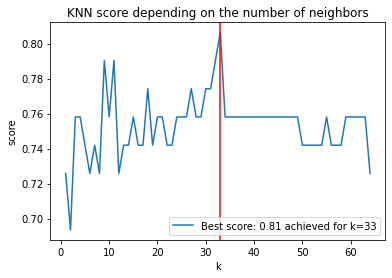

In [17]:
K_list = range(1, K+1)
scores = []
for n in K_list:
    my_KNN = KNeighborsClassifier(n_neighbors=n)
    my_KNN.fit(X_train, y_train)
    scores.append(my_KNN.score(X_test, y_test))
    
best_score = max(scores)
best_k = np.argmax(scores)+1

plt.plot(K_list, scores, label="Best score: "+str(np.round(best_score,2))+" achieved for k="+str(best_k))
plt.axvline(best_k, c="r")
plt.title("KNN score depending on the number of neighbors")
plt.xlabel("k")
plt.ylabel("score")
plt.legend()
plt.savefig("knn.png")
plt.show()

Bayesian KNN achieves a lower score than classical KNN (in this specific example), but it provides more information

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3b829252-08cb-4f6e-a65c-5242d23c5d16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>